In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("../")
device="cuda:0"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

In [2]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

# Content scene

In [3]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)#.to(device=device)
content_scene = Scene(dataset, content_gaussians, shuffle=True)
content_gaussians.training_setup(opt)
# content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog_spheres/chkpnt30000.pth")[0], opt)
content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog_v1/chkpnt30000.pth")[0], opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


## Prepare clusters for the content scene

In [4]:

import torch
import torch.nn.functional as F
from scipy.spatial import distance
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def sample_points_by_density(points, num_samples=None, radius = 0.05, device='cuda'):
    """
    Samples points inversely proportional to their density in the neighborhood.
    :param points: torch tensor of shape [N,3]
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points.
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [num_samples] containing the indices of the sampled points
    """


    # Assuming you have a PyTorch tensor of shape [N, 3] representing points
    # Calculate pairwise distances between all points
    # Note that i only compute distance to every 10th neighbor.
    distances = torch.cdist(points, points[::10])


    # Calculate the number of points within the local region for each point
    num_points_in_local_region = (distances <= radius).sum(dim=1)

    # Calculate the inverse density as a weight
    inverse_density = 1.0 / (num_points_in_local_region + 1)  # Add 1 to avoid division by zero

    # Normalize the weights to create a probability distribution
    probability_distribution = inverse_density / inverse_density.sum()

    # Sample points inversely proportional to their density
    if num_samples is None:
        num_samples = len(points) // 10  # Adjust the number of samples as needed
    sampled_indices = torch.multinomial(probability_distribution, num_samples, replacement=True)

    return sampled_indices
    
def remove_outliers(points, kth_neighbor=30, q=0.925, device='cuda'):
    """
    Removes outliers from the given points. Usually the set of clusters must be small to avoid
    quadratic complexity of the all pairwise neighbors computation.
    :param points: torch tensor of shape [N, 3]
    :param kth_neighbor: this neighbor we use to approximate good neighborhood density.
    :param q: Quantile to use for removing outliers.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A torch tensor of shape [N] containing the indices of the non-outlier points.
    """

    pairwise_distances = torch.cdist(points, points)
    kth_nearest_dists, kth_nearest_indices = torch.topk(pairwise_distances, k=kth_neighbor, dim=1, largest=False, sorted=True)
    q_outliers = torch.quantile(kth_nearest_dists[:, kth_neighbor-1], q=q)
    indcs_relevant = torch.where(kth_nearest_dists[:, kth_neighbor-1] < q_outliers)[0]
    return indcs_relevant

def prepare_scene(points, num_clusters=40, num_samples=None, radius=0.05, q=0.925, device='cuda'):
    """
    Prepares the scene by sampling points and clustering them.
    :param points: torch tensor of shape [N, 3]
    :param num_clusters: Number of clusters to use for KMeans clustering.
    :param num_samples: Number of samples to be drawn according to the
        distribution of densities. If None, then we sample 1/10th of the points from EACH cluster
    :param radius: Radius of the local region around each point at which we compute
        the number of neighbors.
    :param device: Device on which the tensors are stored and computations will be done.
    :return: A tuple containing the following tensors:
    """

     # Use KMeans clustering to find the centroids of the clusters
    kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init=4)
    kmeans.fit(points.detach().cpu().numpy())
    clean_indices = []
    for lbls in np.unique(kmeans.labels_):
        cluster_points_idcs = np.where(kmeans.labels_ == lbls)[0]
        # Remove outliers
        non_outliers_idcs = remove_outliers(points[cluster_points_idcs], q=q, device=device)
        cluster_points_idcs = cluster_points_idcs[non_outliers_idcs.cpu().numpy()]
        # Sample points inversely proportional to the density
        sampled_idcs = sample_points_by_density(points[cluster_points_idcs], num_samples, radius, device)
        cluster_points_idcs = cluster_points_idcs[sampled_idcs.cpu().numpy()]
        clean_indices.append(cluster_points_idcs)

    return clean_indices, kmeans.cluster_centers_, kmeans.labels_[np.concatenate(clean_indices)]


In [5]:
content_shape_idcs, content_shape_cluster_centers, content_shape_cluster_labels = prepare_scene(
    points=content_gaussians._xyz,
    num_samples=None,
    radius=0.035,
    q=0.99975, #0.975,
    num_clusters=80,
    device=device)


In [6]:
content_shape_cluster_centers

array([[-0.17623723, -0.36236686,  0.26601145],
       [ 0.57723033,  0.08083874,  0.21166173],
       [-0.45354348,  0.7098743 , -0.09811886],
       [ 1.0846469 , -0.49576733, -0.08052941],
       [-0.48808295, -1.1423002 , -0.08068854],
       [ 0.13806364,  0.31915185,  0.21370198],
       [ 0.28360802, -1.2236875 , -0.08076039],
       [-0.9321199 , -0.04354498, -0.10402435],
       [ 1.0314968 ,  0.45338067, -0.08009304],
       [ 0.5479392 , -0.8896277 , -0.09129733],
       [ 0.5845115 ,  0.6968688 ,  0.136981  ],
       [ 0.5752048 , -0.3268678 ,  0.19633953],
       [-0.17787218, -0.10690391,  0.27215126],
       [-0.80785155, -0.55904615, -0.10538909],
       [-0.8591947 ,  0.6945982 , -0.07971735],
       [ 0.3136845 , -0.52736557,  0.01347435],
       [ 1.1561403 , -0.04828621, -0.08073293],
       [-0.033547  , -0.47593346,  0.2384189 ],
       [-0.17331728,  0.39418682,  0.28532848],
       [ 0.10030377,  1.0408796 , -0.08572194],
       [ 0.553144  ,  0.49885783,  0.212

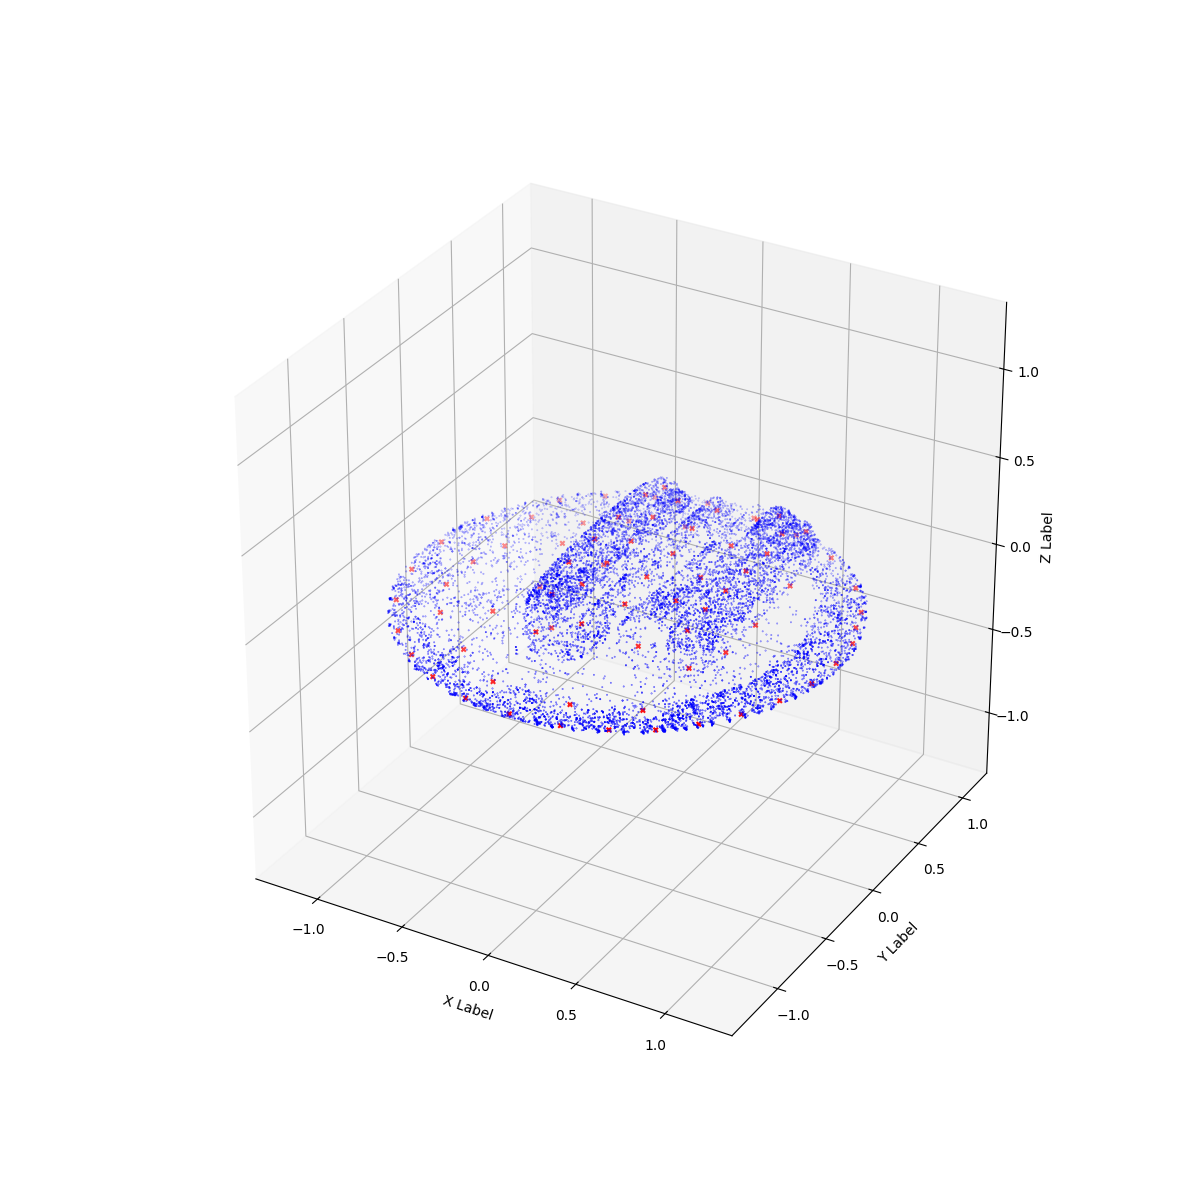

In [7]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = content_gaussians._xyz[np.concatenate(content_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(content_shape_cluster_centers[:, 0],
           content_shape_cluster_centers[:, 1],
           content_shape_cluster_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



# Style scene preparation

## Load single patch.

In [8]:
loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

#loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_brickwall_spheres_clusters_50/cluster_14.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

# 0. only for the bricks scene. Remove poitns underneath. and change size to smaller scale. Multiply coordinates and sizes.
idcs = np.where(gaussians_xyz[:,2]>-0.12)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]




# 1. Remove poitns that are too far away from all other points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)


# Extra increase the volume of the points to make results more apparent
with torch.no_grad():
    # gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for lego
    gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for bricks 

In [9]:
import numpy as np
from scipy.spatial import distance

def get_cluster_radius(cluster_points):
    """
    Computes minimum and maximum of all the largest pairwise distances
    in the cluster. These correspond to the largest inner and largest outter circle.
    Main assumption is that the shape is connected. For flat surfaces use the 
    largest area and decrease it a bit. 
    :param cluster_points: Numpy array of shape [N,d]
    :return inner diameter and outer diameter 
    """

    pairwise_distances = distance.cdist(cluster_points, cluster_points)
    pairwise_max_distances = np.max(pairwise_distances, axis=1)
    outer_max_d = np.max(pairwise_max_distances)
    inner_max_d = np.min(pairwise_max_distances)
    return inner_max_d, outer_max_d


def sample_circles(points, r, min_points_per_cluster=40):
    N, d = points.shape

    # Compute matrix of all pairwise distances
    pairwise_distances = distance.cdist(points, points)

    # Create a boolean array to track covered elements
    covered = np.zeros(N, dtype=bool)

    # List to store the indices of points in each circle
    circles = []

    while not all(covered):
        # Find the index of the next uncovered point
        query_point_idx = np.where(covered == 0)[0][0]
        points_indices_in_circle = []
        r_ = r
        while len(points_indices_in_circle) < min_points_per_cluster:
            points_indices_in_circle = np.where(pairwise_distances[query_point_idx] <= r_)[0]
            r_ = r_*2
        covered[points_indices_in_circle] = True
        # Add the current circle to the list
        circles.append(points_indices_in_circle)

    return circles

d_inter, d_outer = get_cluster_radius(gaussians_xyz)
print("Inter and outer radii of the style patch:", d_inter, d_outer)



domain_circles = sample_circles(points=content_gaussians._xyz.data.detach().cpu().numpy(), r=d_outer * 0.45)
# Remove circles with too few points
domain_circles = [x for x in domain_circles if len(x) > 21]


Inter and outer radii of the style patch: 0.1543036130194805 0.30615902221658997


In [10]:
domain_circles_centers = torch.stack([torch.mean(content_gaussians._xyz.data[domain_circle], dim=0) for domain_circle in domain_circles],
                                     dim=0).detach().cpu().numpy()

In [11]:
domain_circles_centers.shape

(258, 3)

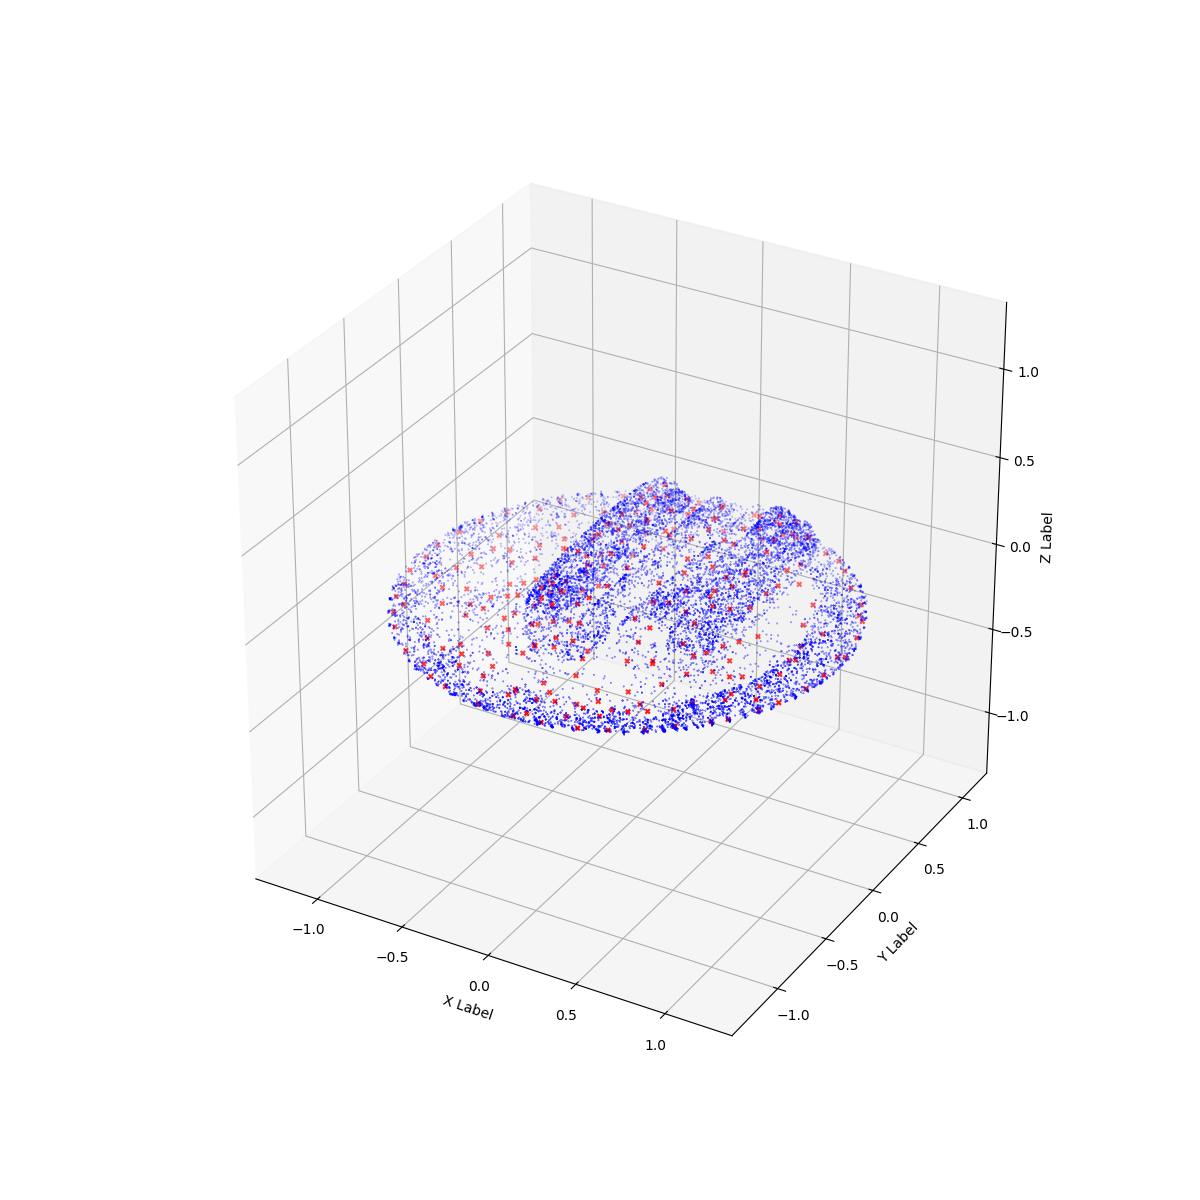

In [12]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr_shape = content_gaussians._xyz[np.concatenate(content_shape_idcs, axis=0)].detach().cpu().numpy()
    ax.scatter(arr_shape[::kth,0], 
               arr_shape[::kth,1], 
               arr_shape[::kth,2], c='b', marker='o',s=0.1)

ax.scatter(domain_circles_centers[:, 0],
           domain_circles_centers[:, 1],
           domain_circles_centers[:, 2],
           c='r', marker='x', s=10.)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



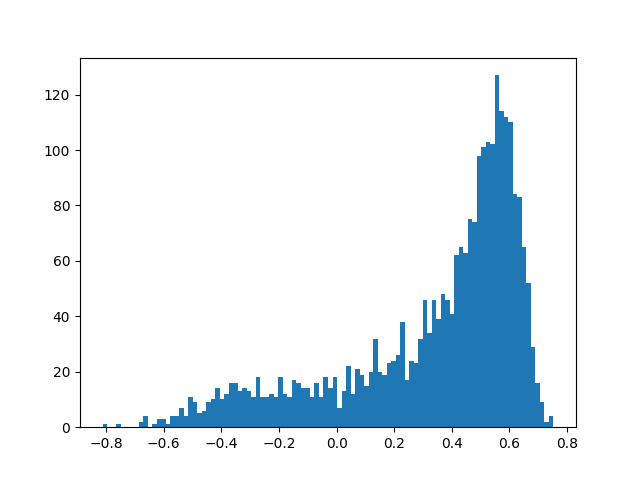

In [13]:
plt.figure()
plt.hist(gaussians_features_dc[..., 2].flatten(), bins=100)
plt.show()

# Now turn that into a colleaction of patches every placed at the position of the content scene cluster

In [14]:
gaussians_opt = GaussianModel(3)#.to(device="cuda")
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [359]:
C = len(content_shape_cluster_centers)
gaussians_opt._features_dc.data = torch.concat([torch.tensor(gaussians_features_dc)]*C).to(device=device)
gaussians_opt._features_rest.data = torch.concat([torch.tensor(gaussians_features_rest)*0.]*C).to(device=device)
gaussians_opt._rotation.data = torch.concat([torch.tensor(gaussians_rotation)]*C).to(device=device)
gaussians_opt._scaling.data = torch.concat([torch.tensor(gaussians_scaling)]*C).to(device=device)
gaussians_opt._opacity.data = torch.concat([torch.tensor(gaussians_opacity)]*C).to(device=device)

N = len(gaussians_xyz)

gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:N])]*C).to(device=device)
gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:N])]*C).to(device=device)
gaussians_opt.denom.data = torch.concat([torch.tensor(content_gaussians.denom[:N])]*C).to(device=device)

/tmp/ipykernel_1972968/2308145428.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.max_radii2D.data = torch.concat([torch.tensor(content_gaussians.max_radii2D[:N])]*C).to(device=device)
/tmp/ipykernel_1972968/2308145428.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.xyz_gradient_accum.data = torch.concat([torch.tensor(content_gaussians.xyz_gradient_accum[:N])]*C).to(device=device)
/tmp/ipykernel_1972968/2308145428.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_opt.denom.data = torch.co

In [360]:
gaussians_opt._scaling.data += 1.5
gaussians_opt._opacity.data += 10.


In [91]:
# gaussians_opt._xyz.data = torch.concat([torch.tensor(gaussians_xyz - np.mean(gaussians_xyz, axis=0) + cluster_center).to(device=device) 
#                                           for cluster_center in content_shape_cluster_centers])

# Make clusters double the size 
gaussians_opt._xyz.data = torch.concat([torch.tensor( (gaussians_xyz - np.mean(gaussians_xyz, axis=0))*2.0 + cluster_center).to(device=device) 
                                          for cluster_center in content_shape_cluster_centers])

In [92]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)

In [93]:
viewpoint_stack = scene_opt.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



In [94]:

render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]



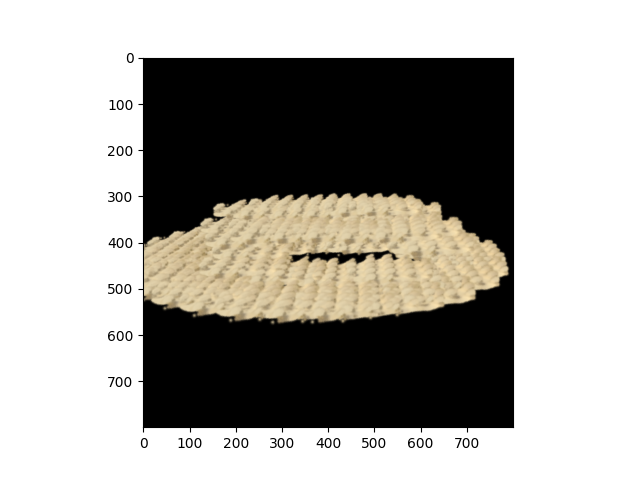

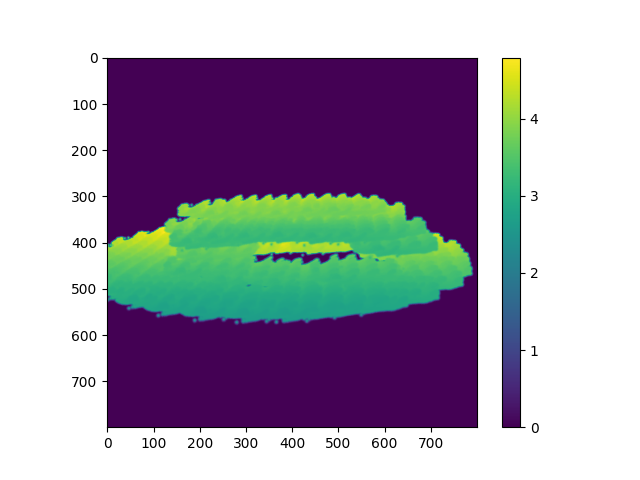

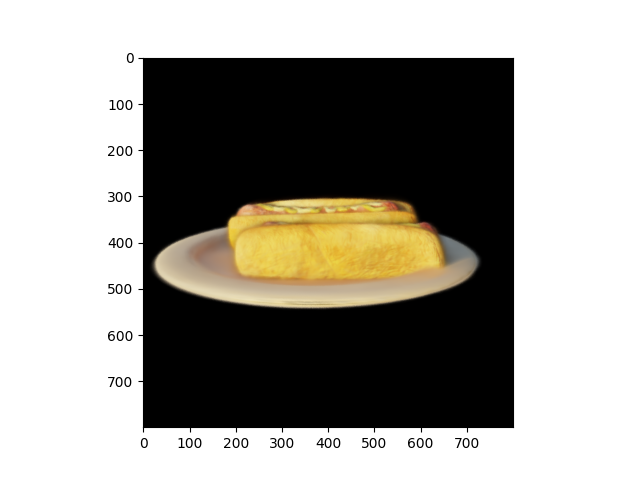

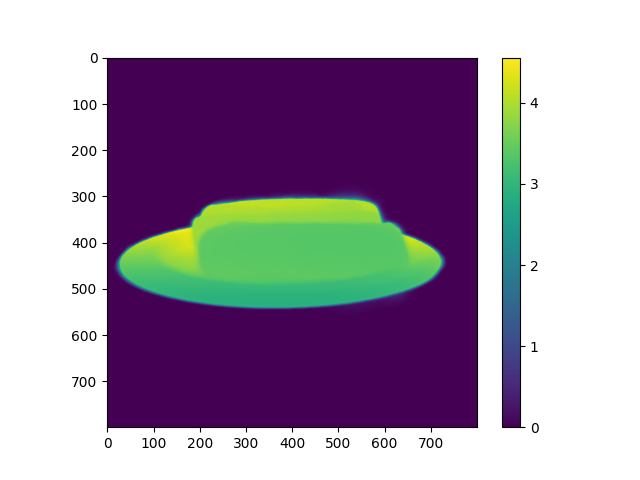

In [95]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [572]:
# with torch.no_grad():
#     content_gaussians._opacity.data = content_gaussians._opacity.data + torch.ones_like(content_gaussians._opacity.data) * 10.
#     content_gaussians._scaling.data = content_gaussians._scaling.data + torch.ones_like(content_gaussians._scaling.data) * 2.5

In [23]:
with torch.no_grad():
    #content_gaussians._opacity.data = content_gaussians._opacity.data - torch.ones_like(content_gaussians._opacity.data) * 10.
    content_gaussians._scaling.data = content_gaussians._scaling.data / 1.15
    content_gaussians._features_rest = content_gaussians._features_rest * 0.

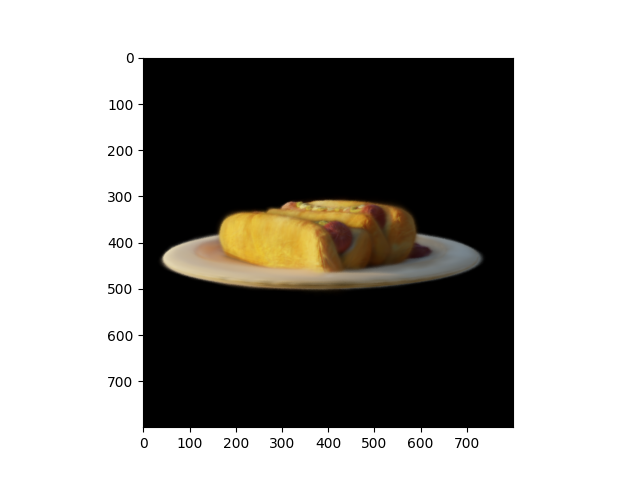

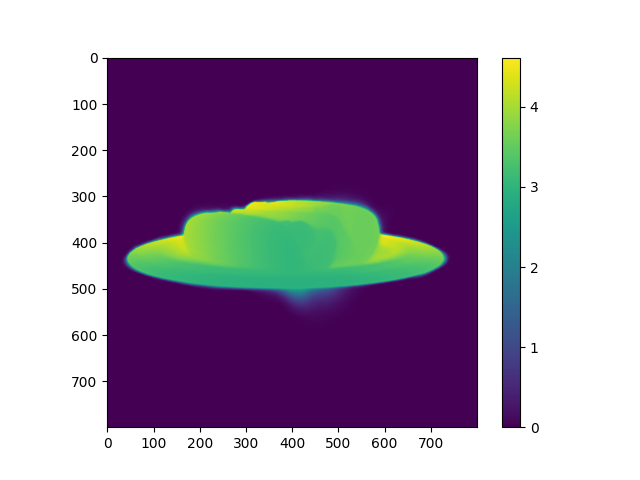

In [24]:
render_pkg_test = render(viewpoint_cam, content_gaussians, pipe, background)
image, depth= render_pkg_test["render"], render_pkg_test["depth"]
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)

# Clip values to be in the range [0, 1]
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()
depth_target = depth.clone().detach().to(device=device)

In [25]:
for attr in ['_xyz', '_features_dc', '_features_rest', '_scaling', '_rotation', '_opacity', 'max_radii2D', 'xyz_gradient_accum', 'denom']:
    print(getattr(gaussians_opt, attr).shape)

torch.Size([217120, 3])
torch.Size([217120, 1, 3])
torch.Size([217120, 15, 3])
torch.Size([217120, 3])
torch.Size([217120, 4])
torch.Size([217120, 1])
torch.Size([217120])
torch.Size([217120, 1])
torch.Size([217120, 1])


## Version 3. Now add local shape descriptors.

In [96]:

def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns
    
def get_style_patch_descriptors_loss(clusters_to_opt_list, nns_indices, target_descriptor_cluster):
    """
    For every cluster of points in the clusters_to_opt_list we compute its descriptor of spatial 
    positions between all pairs of points within this cluster. Afterwards we compare this descriptor
    with the target descriptor.
    """
    loss_local_descriptor_list = []
    loss = 0.
    for cluster_points in clusters_to_opt_list:
        descriptor_points = get_descriptors(X=cluster_points, X_nns_indices=nns_indices)
        loss_local_descriptor = torch.mean(torch.square(descriptor_points - target_descriptor_cluster))
        loss += loss_local_descriptor 
        loss_local_descriptor_list.append(loss_local_descriptor)

    return loss / len(clusters_to_opt_list)


# now find initial desctiptors 

num_nns = 2000
kth_nn = 20
num_nns_local = 100 # was 100
kth_nn_local = 1

distances = torch.cdist(gaussians_opt._xyz.data[:N], gaussians_opt._xyz.data[:N])
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)

nns_indices = nns_indices[:, ::kth_nn]

target_descriptor_cluster = get_descriptors(X=gaussians_opt._xyz.data[:N], 
                                            X_nns_indices=nns_indices)
target_descriptor_cluster = target_descriptor_cluster.clone().detach()
target_descriptor_cluster.shape


torch.Size([2714, 99])

In [97]:


get_style_patch_descriptors_loss(clusters_to_opt_list=[gaussians_opt._xyz[:N]],
                                 nns_indices=nns_indices,
                                 target_descriptor_cluster=target_descriptor_cluster)



tensor(0., device='cuda:0', grad_fn=<DivBackward0>)

In [28]:
losses=[]


gaussians_opt._xyz.requires_grad_ = False
gaussians_opt._features_dc.requires_grad_ = True
gaussians_opt._features_rest.requires_grad_ = False
gaussians_opt._scaling.requires_grad_ = False
gaussians_opt._rotation.requires_grad_ = False
gaussians_opt._opacity.requires_grad_ = False
gaussians_opt.max_radii2D.requires_grad_ = False


gaussians_opt.training_setup(opt)
for param_group in gaussians_opt.optimizer.param_groups:
        param_group['lr'] = 1e-2

gaussians_opt._xyz.requires_grad_ = False
gaussians_opt._features_dc.requires_grad_ = True
gaussians_opt._features_rest.requires_grad_ = False
gaussians_opt._scaling.requires_grad_ = False
gaussians_opt._rotation.requires_grad_ = False
gaussians_opt._opacity.requires_grad_ = False
gaussians_opt.max_radii2D.requires_grad_ = False


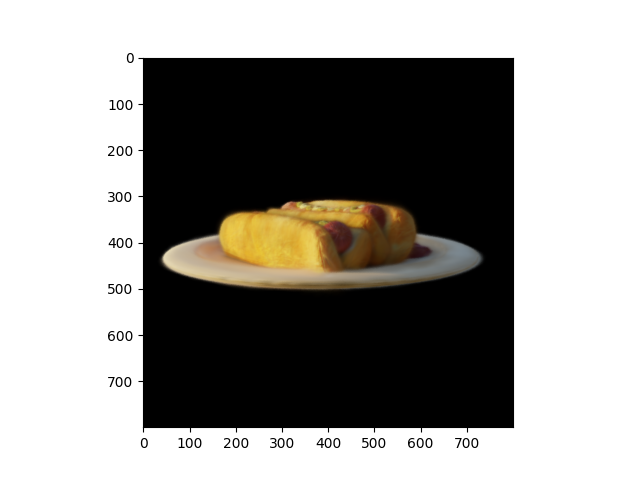

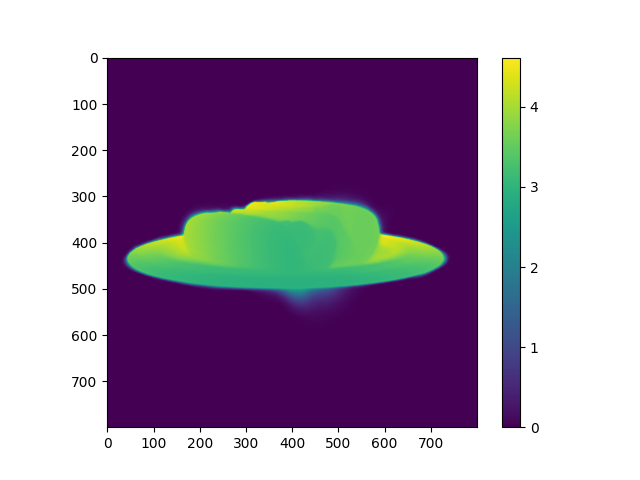

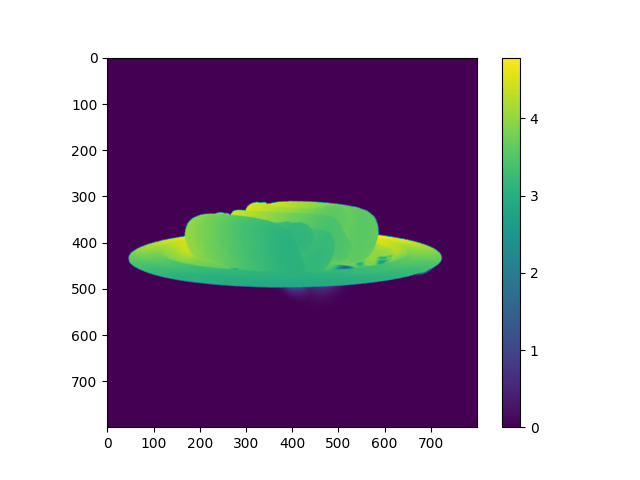

In [29]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [98]:


# def loss_to_depth_target(d, d_trg):
#     return torch.mean(torch.square(d - d_trg) * (d_trg>0.5))

def loss_to_depth_target(d, d_trg):
    return torch.mean(torch.square(d - d_trg))


from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(31, 31), sigma=(30., 30.))


from math import ceil

import torch
from torch.nn.functional import conv2d
from torch.distributions import Normal

# Taken from here https://stackoverflow.com/questions/60534909/gaussian-filter-in-pytorch
def gaussian_kernel_1d(sigma: float, num_sigmas: float = 3.) -> torch.Tensor:
    
    radius = ceil(num_sigmas * sigma)
    support = torch.arange(-radius, radius + 1, dtype=torch.float)
    kernel = Normal(loc=0, scale=sigma).log_prob(support).exp_()
    # Ensure kernel weights sum to 1, so that image brightness is not altered
    return kernel.mul_(1 / kernel.sum()).cuda()

def gaussian_filter_2d(img: torch.Tensor, sigma: float) -> torch.Tensor:
    
    kernel_1d = gaussian_kernel_1d(sigma)  # Create 1D Gaussian kernel
    
    padding = len(kernel_1d) // 2  # Ensure that image size does not change
    img = img.unsqueeze(0).unsqueeze_(0)  # Need 4D data for ``conv2d()``
    # Convolve along columns and rows
    img = conv2d(img, weight=kernel_1d.view(1, 1, -1, 1), padding=(padding, 0))
    img = conv2d(img, weight=kernel_1d.view(1, 1, 1, -1), padding=(0, padding))
    return img.squeeze_(0).squeeze_(0)  # Make 2D again
def loss_to_depth_target(d, d_trg, make_BG_large=False, blur_depth=False, blr_sgm=1.):
    d_ = d
    d_trg_ = d_trg
    if make_BG_large:
        d_trg_ = d_trg_ + (d_trg_<1e-2) * 1e2
    if blur_depth:
        d_ = gaussian_filter_2d(d_, sigma=blr_sgm)
        d_trg_ = gaussian_filter_2d(d_trg_, sigma=blr_sgm)
    return torch.mean(torch.square(d_ - d_trg_))# * (d_trg>0.01))
    

In [31]:
if False:
    # Custom optimizer
    
    optim = torch.optim.Adam([gaussians_opt._features_dc], lr=1e-2)
    
    
    if True:
        for step in tqdm(range(5001)):
            optim.zero_grad()
            # Pick a random Camera
            
            if not viewpoint_stack:
                viewpoint_stack = scene_opt.getTrainCameras().copy()
            
            # if step < 2:
            viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
            # Optimization gaussians
            render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
            image, depth= render_pkg["render"], render_pkg["depth"]
            # Content gaussians
            render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
            image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
    
            depth_target = depth_cont.clone().detach().to(device=device)
    
            
            
            #depth_target = torch.ones_like(depth)*2.
            loss_depth = loss_to_depth_target(d=depth, d_trg=depth_cont, make_BG_large=False, blur_depth=True)
    
            # loss_img_mask = loss_to_depth_target(d=torch.mean((image>0.05).to(torch.float32), dim=0), 
            #                                      d_trg=torch.mean((image_cont>0.05).to(torch.float32), dim=0), 
            #                                      make_BG_large=False, 
            #                                      blur_depth=True)
    
            loss_descriptor_local = get_style_patch_descriptors_loss(
                clusters_to_opt_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)],
                nns_indices=nns_indices,
                target_descriptor_cluster=target_descriptor_cluster)
    
            #loss_pixel = torch.mean(torch.square(image - image_cont))
            # loss_pixel = torch.mean(torch.square((torch.mean(image, dim=0) > 0.1).to(torch.float32) - 
            #                                      (torch.mean(image_cont, dim=0) > 0.1).to(torch.float32)))
    
            loss_pixel = torch.mean(torch.square((torch.mean(image, dim=0)).to(torch.float32) - 
                                                 (torch.mean(image_cont, dim=0)).to(torch.float32)))
            
            loss_img_mask = 0.
            # loss_descriptor_local = 0.
            
    
            # Weighting of losses
            loss_descriptor_local = loss_descriptor_local * 1.
            loss_depth = loss_depth * 1.
            loss_img_mask = loss_img_mask *0. 
            loss_pixel = loss_pixel * 1.
            
            # Stage 1. Only Pixels.
            loss = loss_depth*1e1 + loss_descriptor_local*1e3 + loss_img_mask*0e0 + loss_pixel*1e0
            # loss = loss_depth*1e-1 + loss_descriptor_local*1e4 + loss_img_mask*0e0 + loss_pixel*1e0
            # loss = loss_depth*1e-1 + loss_descriptor_local*1e5 + loss_img_mask*0e0 + loss_pixel*1e0
            # loss = loss_depth*1e-1 + loss_descriptor_local*1e6 + loss_img_mask*0e0 + loss_pixel*1e0
            # loss = loss_depth*0e-1 + loss_descriptor_local*1e6 + loss_img_mask*0e0 + loss_pixel*0e0
            # Stage 1. Only depth.
            #loss = loss_depth*1e1 + loss_descriptor_local*0e3 + loss_img_mask*0e0 + loss_pixel*0e0
            # Stage 2. all jointly
            #loss = loss_depth*1e1 + loss_descriptor_local*2e3 + loss_img_mask*0e0 + loss_pixel*1e0
            loss.backward()
        
            optim.step()
            losses.append(float(loss.detach().cpu().numpy()))#loss.cpu().numpy)
            
            if step % 100 == 0:
                print(losses[-1])
                print(f"loss_depth:{loss_depth:.7f}, loss_descriptor_local:{loss_descriptor_local:.7f},",
                      f"loss_img_mask:{loss_img_mask:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")
    
       



/tmp/ipykernel_1972968/3139979824.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

9.390998840332031
loss_depth:0.9333123, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0578760, loss:9.3909988
25.932334899902344
loss_depth:2.5864513, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0678210, loss:25.9323349
13.400269508361816
loss_depth:1.3375189, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0250808, loss:13.4002695
14.151415824890137
loss_depth:1.4135381, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0160350, loss:14.1514158
12.182427406311035
loss_depth:1.2173443, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0089848, loss:12.1824274
30.472639083862305
loss_depth:3.0463836, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0088019, loss:30.4726391
19.15154457092285
loss_depth:1.9144648, loss_descriptor_local:0.0000000, loss_img_mask:0.0000000, loss_pixel:0.0068962, loss:19.1515446
10.562837600708008
loss_depth:1.0557557, los

KeyboardInterrupt: 

In [328]:

# Custom optimizer

optim = torch.optim.Adam([gaussians_opt._xyz, gaussians_opt._features_dc, gaussians_opt._scaling], lr=1e-3)


In [329]:
# old_coords = gaussians_opt._xyz.data.clone().detach()

In [361]:
with torch.no_grad():
    #gaussians_opt._xyz.data = gaussians_opt._xyz.data + torch.randn_like(gaussians_opt._xyz) / 1.

    
    # Make clusters double the size 
    gaussians_opt._xyz.data = torch.concat([torch.tensor( 
        (gaussians_xyz - np.mean(gaussians_xyz, axis=0))*2.0 + np.random.normal(size=gaussians_xyz.shape).astype(np.float32) / 3e8 + cluster_center).to(device=device) 
                                              for cluster_center in content_shape_cluster_centers])

In [346]:
losses = []

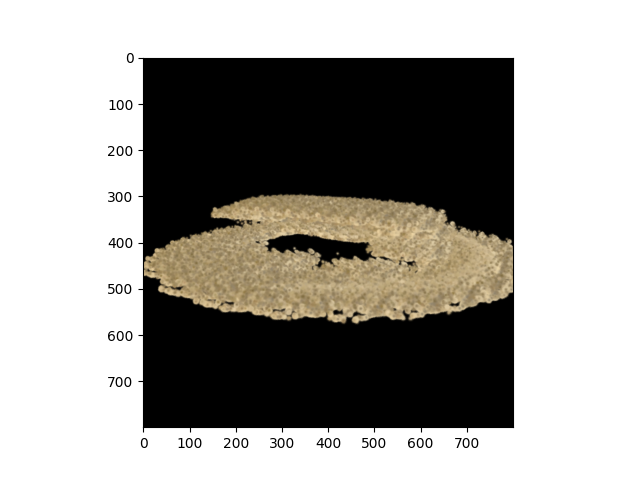

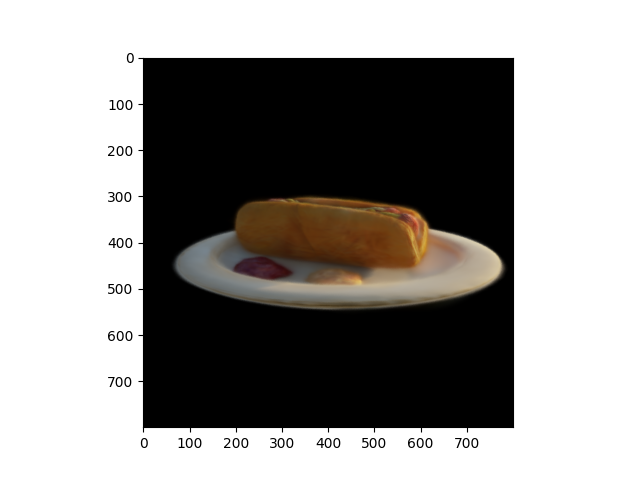

In [365]:
#viewpoint_cam_fixed = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_fixed = render(viewpoint_cam_fixed, gaussians_opt, pipe, background)
image, depth= render_pkg_fixed["render"], render_pkg_fixed["depth"]

render_pkg_fixed_cont = render(viewpoint_cam_fixed, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_fixed_cont["render"], render_pkg_fixed_cont["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()






In [349]:



if True:
    for step in tqdm(range(5001)):
        optim.zero_grad()
        # Pick a random Camera
        
        if not viewpoint_stack:
            viewpoint_stack = scene_opt.getTrainCameras().copy()
        
        # if step < 2:
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        # Optimization gaussians
        render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
        image, depth= render_pkg["render"], render_pkg["depth"]
        # Content gaussians
        render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
        image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

        depth_target = depth_cont.clone().detach().to(device=device)

        
        
        #depth_target = torch.ones_like(depth)*2.
        loss_depth = loss_to_depth_target(d=depth, d_trg=depth_cont, make_BG_large=False, blur_depth=True)

        loss_img_mask = loss_to_depth_target(d=torch.mean((image>0.05).to(torch.float32), dim=-1), 
                                             d_trg=torch.mean((image_cont>0.05).to(torch.float32), dim=-1), 
                                             make_BG_large=False, 
                                             blur_depth=True,
                                             blr_sgm=10.)

        loss_descriptor_local = get_style_patch_descriptors_loss(
            clusters_to_opt_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)],
            nns_indices=nns_indices,
            target_descriptor_cluster=target_descriptor_cluster)

        #loss_pixel = torch.mean(torch.square(image - image_cont))
        # loss_pixel = torch.mean(torch.square((torch.mean(image, dim=0) > 0.1).to(torch.float32) - 
        #                                      (torch.mean(image_cont, dim=0) > 0.1).to(torch.float32)))

        # loss_pixel = torch.mean(torch.square((torch.mean(image, dim=0)).to(torch.float32) - 
        #                                      (torch.mean(image_cont, dim=0)).to(torch.float32)))
        loss_pixel = torch.mean(torch.square(
            gaussian_filter_2d((torch.mean(image, dim=0)).to(torch.float32), sigma=10) - 
            gaussian_filter_2d((torch.mean(image_cont, dim=0)).to(torch.float32), sigma=10)))

        #loss_pixel = torch.mean(torch.square(image - image_cont))
        #loss_img_mask = torch.mean(torch.square(image > 0.05 - image_cont >0.05))
        

        # Weighting of losses
        loss_descriptor_local = loss_descriptor_local * 1.
        loss_depth = loss_depth * 1.
        loss_img_mask = loss_img_mask *1. 
        loss_pixel = loss_pixel * 1.
        
        # Stage 1. Only Pixels.
        #loss = loss_depth*0e1 + loss_descriptor_local*0e3 + loss_img_mask*0e0 + loss_pixel*1e0
        # Stage 1. Only depth, pixels and local desctiptors
        # loss = loss_depth*1e1 + loss_descriptor_local*1e3 + loss_img_mask*0e0 + loss_pixel*1e0
        # Stage 1. Only pixels
        # loss = loss_depth*0e1 + loss_descriptor_local*0e3 + loss_img_mask*0e0 + loss_pixel*1e0
        # Stage 1. pixels with local desctiptors
        # loss = loss_depth*1e-1 + loss_descriptor_local*1e5 + loss_img_mask*0e0 + loss_pixel*1e0
         
        # loss = loss_depth*1e0 + loss_descriptor_local*1e3 + loss_img_mask*1e2 + loss_pixel*1e0

        loss = loss_depth*1e0 + loss_pixel * 0e1 + loss_descriptor_local*0e4
        # loss = loss_img_mask*1e2
        # loss = loss_depth*1e-1 + loss_descriptor_local*1e4 + loss_img_mask*0e0 + loss_pixel*1e0
        # loss = loss_depth*1e-1 + loss_descriptor_local*1e5 + loss_img_mask*0e0 + loss_pixel*1e0
        # loss = loss_depth*1e-1 + loss_descriptor_local*1e6 + loss_img_mask*0e0 + loss_pixel*1e0
        # loss = loss_depth*0e-1 + loss_descriptor_local*1e6 + loss_img_mask*0e0 + loss_pixel*0e0
        # Stage 1. Only depth.
        #loss = loss_depth*1e1 + loss_descriptor_local*0e3 + loss_img_mask*0e0 + loss_pixel*0e0
        # Stage 2. all jointly
        #loss = loss_depth*1e1 + loss_descriptor_local*2e3 + loss_img_mask*0e0 + loss_pixel*1e0
        loss.backward()
    
        optim.step()
        losses.append(float(loss.detach().cpu().numpy()))#loss.cpu().numpy)
        
        if step % 100 == 0:
            print(losses[-1])
            print(f"loss_depth:{loss_depth:.7f}, loss_descriptor_local:{loss_descriptor_local:.7f},",
                  f"loss_img_mask:{loss_img_mask:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")

   



/tmp/ipykernel_1972968/1993116936.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

2.2771308422088623
loss_depth:2.2771308, loss_descriptor_local:0.0000000, loss_img_mask:0.0005942, loss_pixel:0.1064760, loss:2.2771308
2.2707691192626953
loss_depth:2.2707691, loss_descriptor_local:0.0000002, loss_img_mask:0.0005942, loss_pixel:0.1212415, loss:2.2707691
0.7745049595832825
loss_depth:0.7745050, loss_descriptor_local:0.0000009, loss_img_mask:0.0002120, loss_pixel:0.0369679, loss:0.7745050
1.7628400325775146
loss_depth:1.7628400, loss_descriptor_local:0.0000025, loss_img_mask:0.0005923, loss_pixel:0.0986309, loss:1.7628400
1.577617883682251
loss_depth:1.5776179, loss_descriptor_local:0.0000048, loss_img_mask:0.0006140, loss_pixel:0.0805534, loss:1.5776179


KeyboardInterrupt: 

In [391]:

optim = torch.optim.Adam([gaussians_opt._xyz, gaussians_opt._features_dc, gaussians_opt._scaling], lr=1e-3)

optim = torch.optim.Adam([gaussians_opt._xyz], lr=1e-4)
losses = []

In [ ]:


sigma=3.
if True:
    for step in tqdm(range(5001)):
        optim.zero_grad()
        # Pick a random Camera
        
        if not viewpoint_stack:
            viewpoint_stack = scene_opt.getTrainCameras().copy()
        
        # if step < 2:
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        # Optimization gaussians
        render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
        image, depth= render_pkg["render"], render_pkg["depth"]
        # Content gaussians
        render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
        image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
        
        image_cont = torch.clamp(image_cont*2, 0., 1.) 

        depth_target = depth_cont.clone().detach().to(device=device)

        
        
        #depth_target = torch.ones_like(depth)*2.
        loss_depth = loss_to_depth_target(d=depth, d_trg=depth_cont, make_BG_large=False, blur_depth=True)

        loss_img_mask = loss_to_depth_target(d=torch.mean((image>0.05).to(torch.float32), dim=-1), 
                                             d_trg=torch.mean((image_cont>0.05).to(torch.float32), dim=-1), 
                                             make_BG_large=False, 
                                             blur_depth=True,
                                             blr_sgm=10.)

        loss_descriptor_local = get_style_patch_descriptors_loss(
            clusters_to_opt_list=[gaussians_opt._xyz[i*N:(i+1)*N] for i in range(C)],
            nns_indices=nns_indices,
            target_descriptor_cluster=target_descriptor_cluster)

        loss_depth = torch.mean(torch.square(
            gaussian_filter_2d(depth, sigma=1) - gaussian_filter_2d(depth_cont, sigma=sigma)))
        
        loss_pixel = torch.mean(torch.square(
            gaussian_filter_2d((torch.mean(image, dim=0)).to(torch.float32), sigma=sigma) - 
            gaussian_filter_2d((torch.mean(image_cont, dim=0)).to(torch.float32), sigma=sigma)))

        

        # Weighting of losses
        loss_descriptor_local = loss_descriptor_local * 1.
        loss_depth = loss_depth * 1.
        loss_img_mask = loss_img_mask *1. 
        loss_pixel = loss_pixel * 1.
        

        loss = loss_depth*1e0 + loss_pixel * 1e1 + loss_descriptor_local*0e4

        
        loss = loss_depth*1e0 + loss_pixel * 1e1 + loss_descriptor_local*0e4

        loss = loss_descriptor_local*1e4

        loss = loss_depth*1e0 + loss_pixel * 1e1 + loss_descriptor_local*1e4
        loss.backward()
    
        optim.step()
        losses.append(float(loss.detach().cpu().numpy()))#loss.cpu().numpy)
        
        if step % 100 == 0:
            print(losses[-1])
            print(f"loss_depth:{loss_depth:.7f}, loss_descriptor_local:{loss_descriptor_local:.7f},",
                  f"loss_img_mask:{loss_img_mask:.7f}, loss_pixel:{loss_pixel:.7f}, loss:{loss:.7f}")

   



/tmp/ipykernel_1972968/3241629481.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

0.7714805603027344
loss_depth:0.4364974, loss_descriptor_local:0.0000181, loss_img_mask:0.0000350, loss_pixel:0.0153978, loss:0.7714806
1.0861411094665527
loss_depth:0.7236477, loss_descriptor_local:0.0000160, loss_img_mask:0.0001124, loss_pixel:0.0202457, loss:1.0861411
0.6835646033287048
loss_depth:0.4021538, loss_descriptor_local:0.0000145, loss_img_mask:0.0000257, loss_pixel:0.0136340, loss:0.6835646
0.7861804962158203
loss_depth:0.4919428, loss_descriptor_local:0.0000134, loss_img_mask:0.0000358, loss_pixel:0.0159765, loss:0.7861805
0.9117431044578552
loss_depth:0.6095718, loss_descriptor_local:0.0000124, loss_img_mask:0.0000786, loss_pixel:0.0178275, loss:0.9117431
1.1308541297912598
loss_depth:0.8060805, loss_descriptor_local:0.0000115, loss_img_mask:0.0000953, loss_pixel:0.0209700, loss:1.1308541
1.3852427005767822
loss_depth:1.0204339, loss_descriptor_local:0.0000106, loss_img_mask:0.0001702, loss_pixel:0.0259118, loss:1.3852427
0.7097331881523132
loss_depth:0.4572744, loss_de

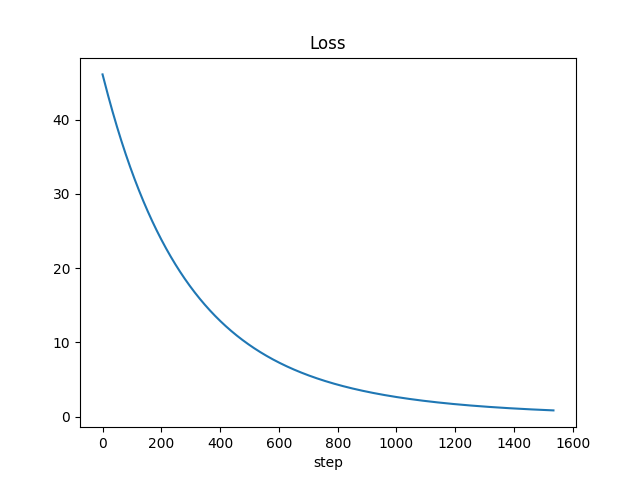

In [393]:
# plt.plot([x.cpu() for x in losses])
plt.figure()
plt.title("Loss")
plt.xlabel("step")
plt.plot(losses)#np.stack([x.cpu().detach().numpy() for x in losses]))

plt.show()


In [389]:
#gaussians_opt._features_dc.data = torch.concat([torch.tensor(gaussians_features_dc)]*C).to(device=device)
#gaussians_opt._features_rest.data = torch.concat([torch.tensor(gaussians_features_rest)*0.]*C).to(device=device)
#gaussians_opt._rotation.data = torch.concat([torch.tensor(gaussians_rotation)]*C).to(device=device)
gaussians_opt._scaling.data = torch.concat([torch.tensor(gaussians_scaling)]*C).to(device=device)
gaussians_opt._opacity.data = torch.concat([torch.tensor(gaussians_opacity)]*C).to(device=device)

gaussians_opt._scaling.data += 1.5
gaussians_opt._opacity.data += 10.


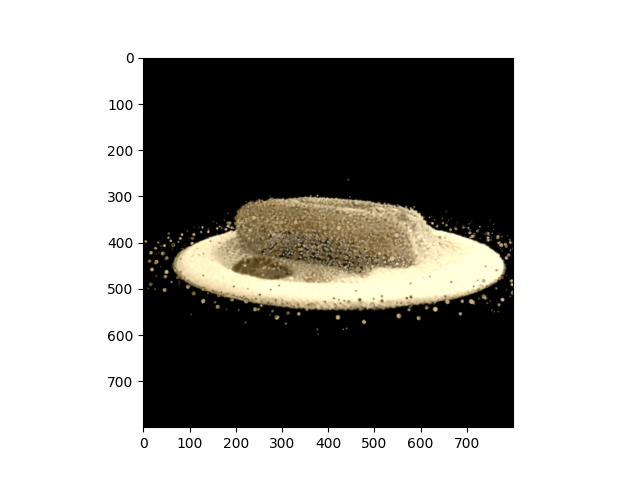

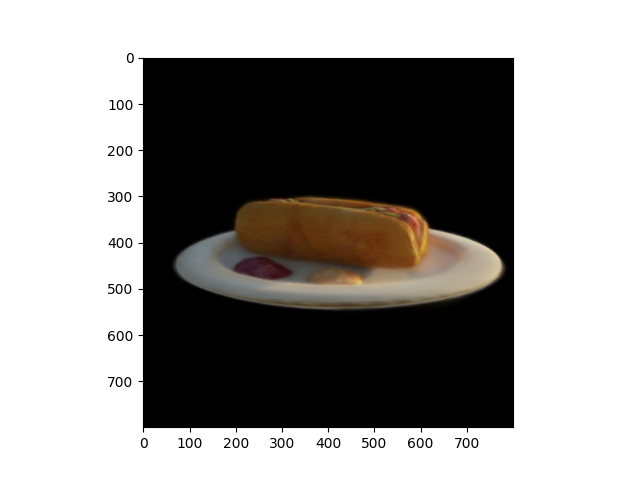

In [383]:
render_pkg_fixed = render(viewpoint_cam_fixed, gaussians_opt, pipe, background)
image, depth= render_pkg_fixed["render"], render_pkg_fixed["depth"]

render_pkg_fixed_cont = render(viewpoint_cam_fixed, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_fixed_cont["render"], render_pkg_fixed_cont["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

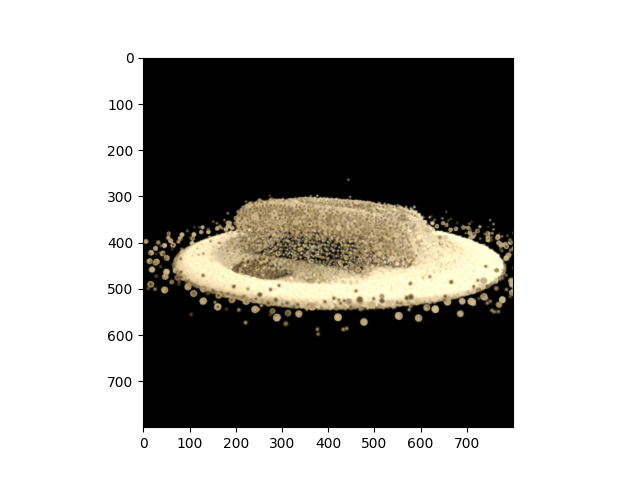

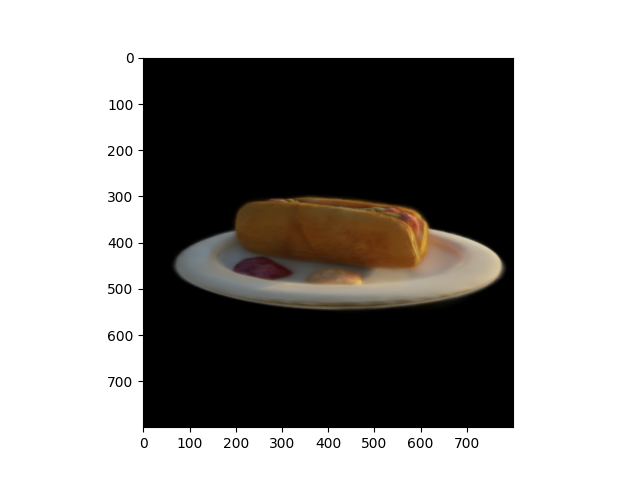

In [390]:
render_pkg_fixed = render(viewpoint_cam_fixed, gaussians_opt, pipe, background)
image, depth= render_pkg_fixed["render"], render_pkg_fixed["depth"]

render_pkg_fixed_cont = render(viewpoint_cam_fixed, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_fixed_cont["render"], render_pkg_fixed_cont["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

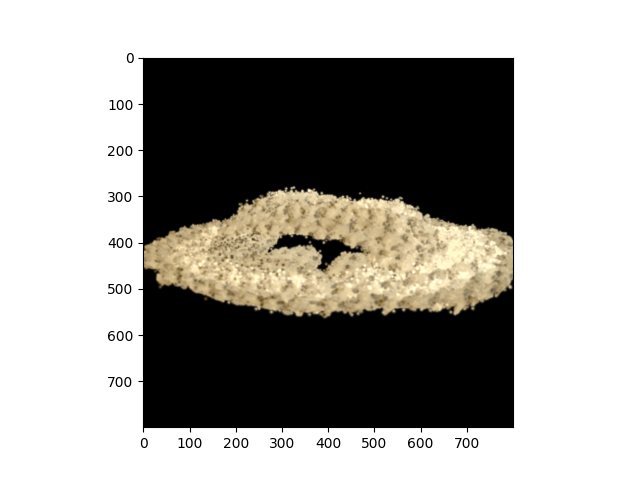

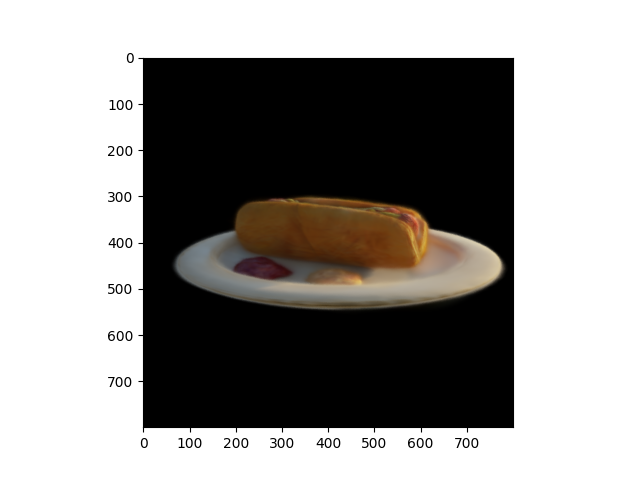

In [394]:
render_pkg_fixed = render(viewpoint_cam_fixed, gaussians_opt, pipe, background)
image, depth= render_pkg_fixed["render"], render_pkg_fixed["depth"]

render_pkg_fixed_cont = render(viewpoint_cam_fixed, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_fixed_cont["render"], render_pkg_fixed_cont["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

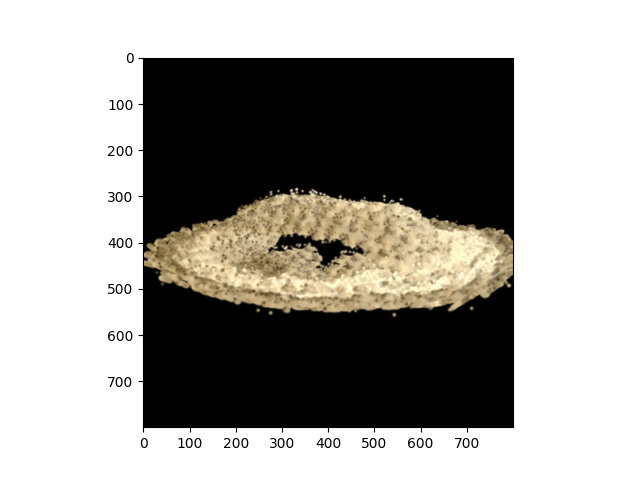

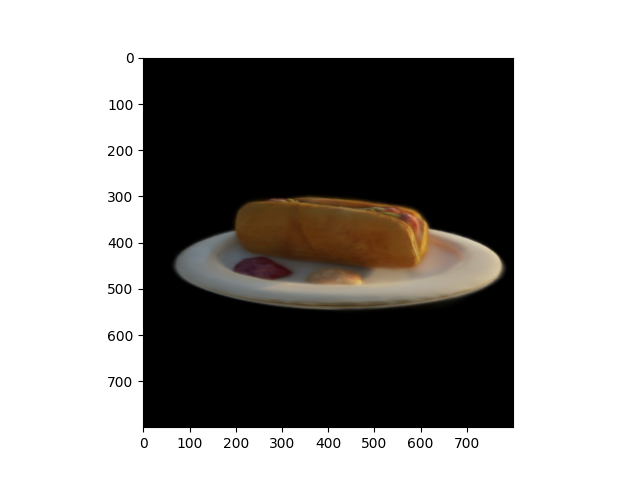

In [396]:
render_pkg_fixed = render(viewpoint_cam_fixed, gaussians_opt, pipe, background)
image, depth= render_pkg_fixed["render"], render_pkg_fixed["depth"]

render_pkg_fixed_cont = render(viewpoint_cam_fixed, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_fixed_cont["render"], render_pkg_fixed_cont["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

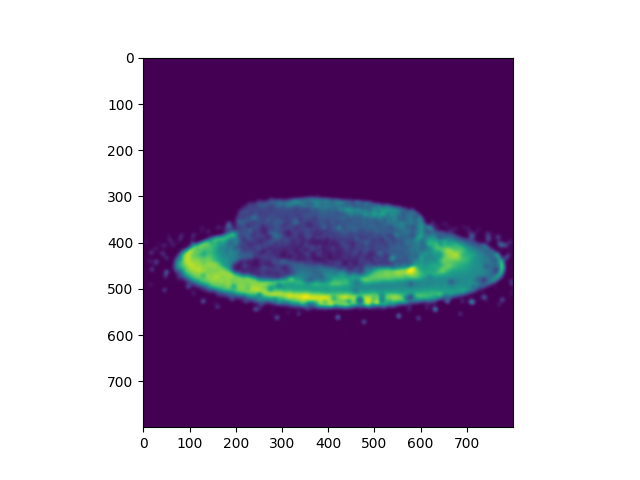

In [384]:
loss_pixel_imgs = torch.square(gaussian_filter_2d((torch.mean(image, dim=0)).to(torch.float32), sigma=5.) - 
                               gaussian_filter_2d((torch.mean(image_cont, dim=0)).to(torch.float32), sigma=5.))

plt.figure()
plt.imshow(loss_pixel_imgs.detach().clone().cpu().numpy())
plt.show()

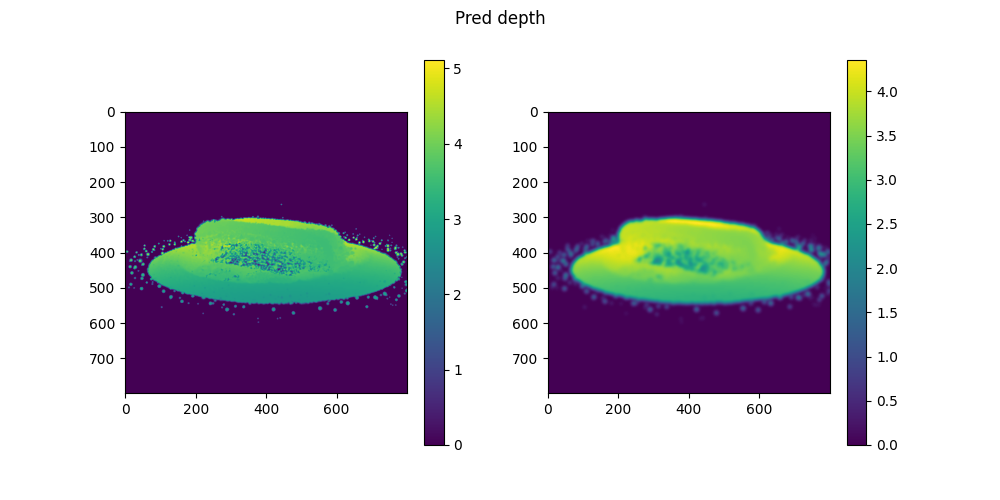

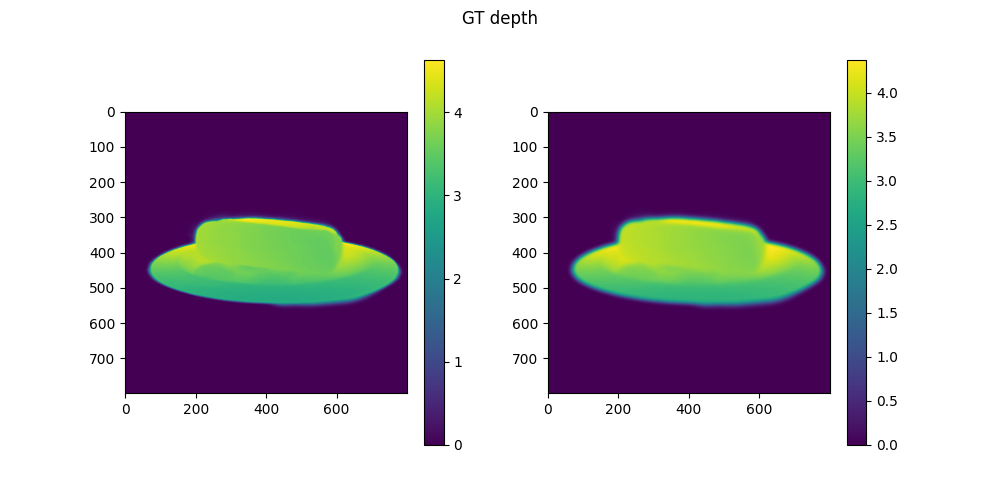

In [385]:

depth_np = depth.detach().cpu().numpy()
depth_np_blurred =  gaussian_filter_2d(depth, sigma=5.).detach().cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Pred depth")
ax0 = ax[0].imshow(depth_np)
ax1 = ax[1].imshow(depth_np_blurred)
fig.colorbar(ax0, ax=ax[0])
fig.colorbar(ax1, ax=ax[1])
plt.show()

depth_np = depth_cont.detach().cpu().numpy()
depth_np_blurred =  gaussian_filter_2d(depth_cont, sigma=5.).detach().cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("GT depth")
ax0 = ax[0].imshow(depth_np)
ax1 = ax[1].imshow(depth_np_blurred)
fig.colorbar(ax0, ax=ax[0])
fig.colorbar(ax1, ax=ax[1])
plt.show()


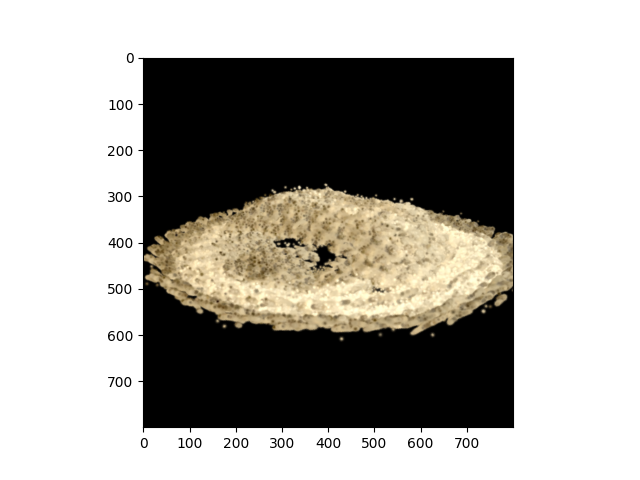

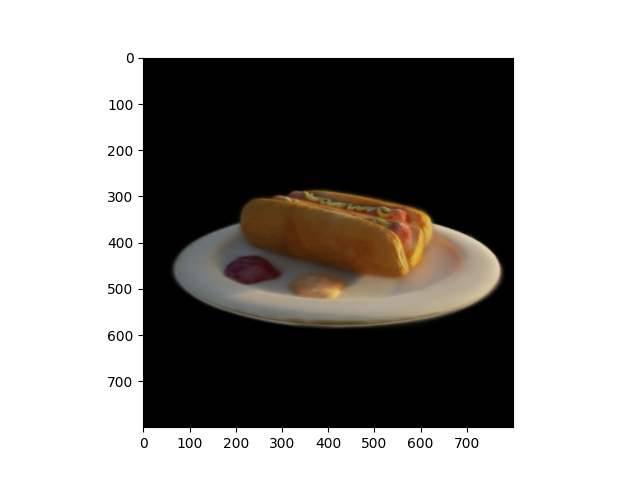

In [401]:
viewpoint_cam_novel = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_novel = render(viewpoint_cam_novel, gaussians_opt, pipe, background)
image, depth= render_pkg_novel["render"], render_pkg_novel["depth"]

render_pkg_novel_cont = render(viewpoint_cam_novel, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_novel_cont["render"], render_pkg_novel_cont["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()






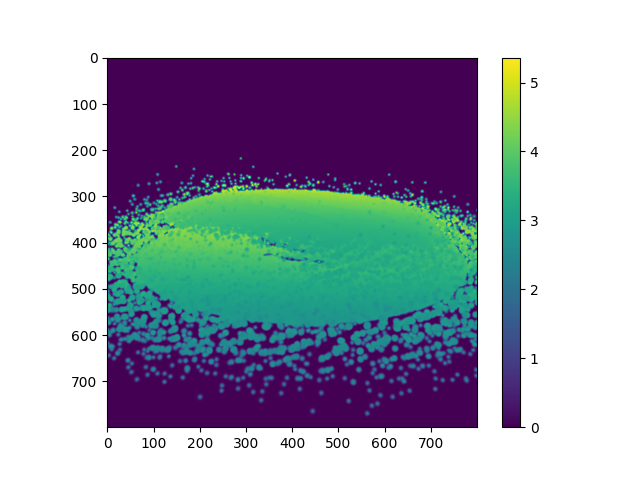

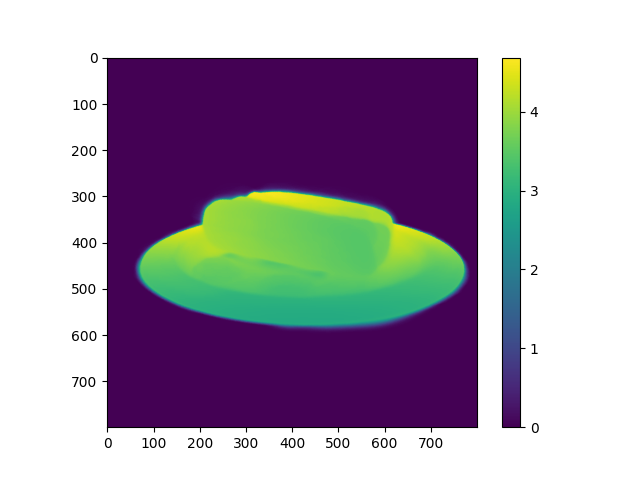

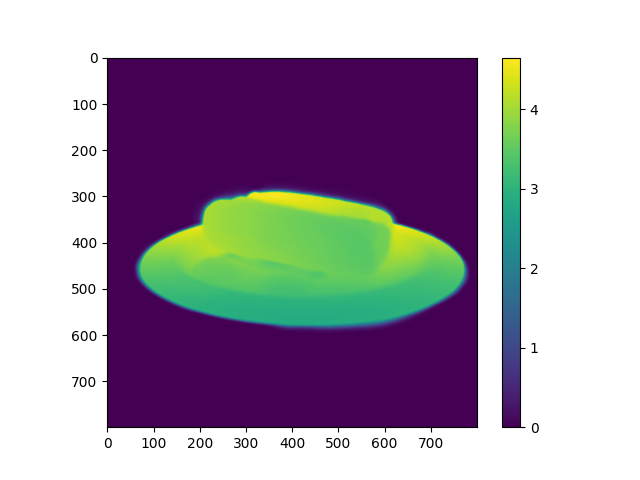

In [171]:

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()




    
depth_np = gaussian_filter_2d(depth_cont, sigma=1.).detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

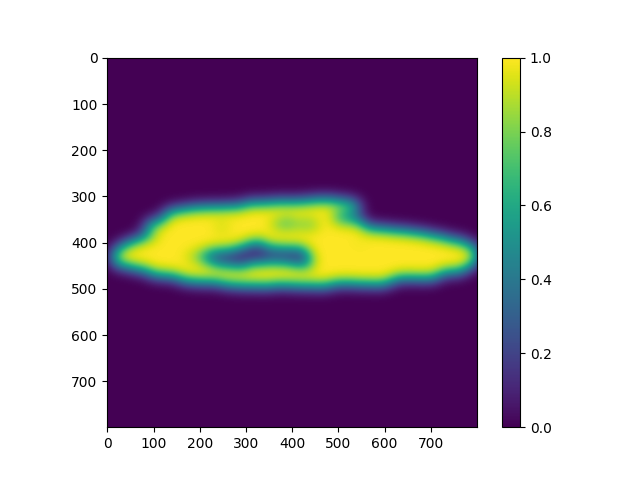

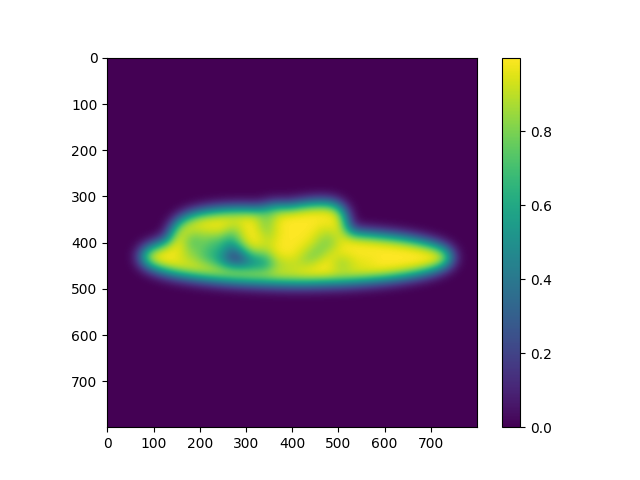

In [581]:
im_rgb = torch.mean((image>0.05).to(torch.float32), dim=0)

im_rgb = gaussian_filter_2d(im_rgb, sigma=15.5)
im_rgb = im_rgb.detach().cpu().numpy()

plt.figure()
plt.imshow(im_rgb)
plt.colorbar()
plt.show()


im_rgb = torch.mean((image_cont>0.05).to(torch.float32), dim=0)

im_rgb = gaussian_filter_2d(im_rgb, sigma=15.5)
im_rgb = im_rgb.detach().cpu().numpy()

plt.figure()
plt.imshow(im_rgb)
plt.colorbar()
plt.show()

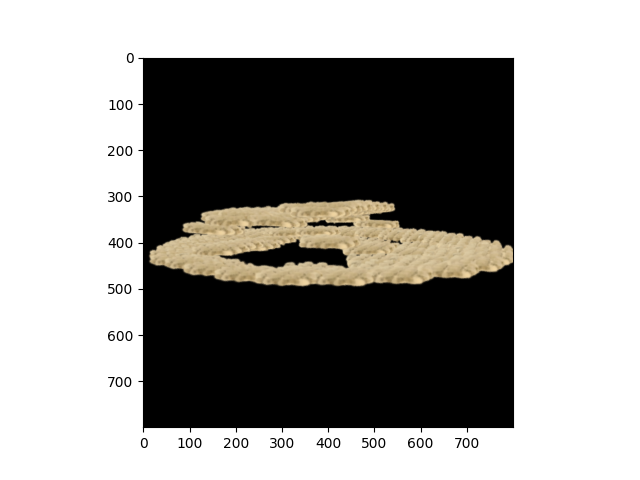

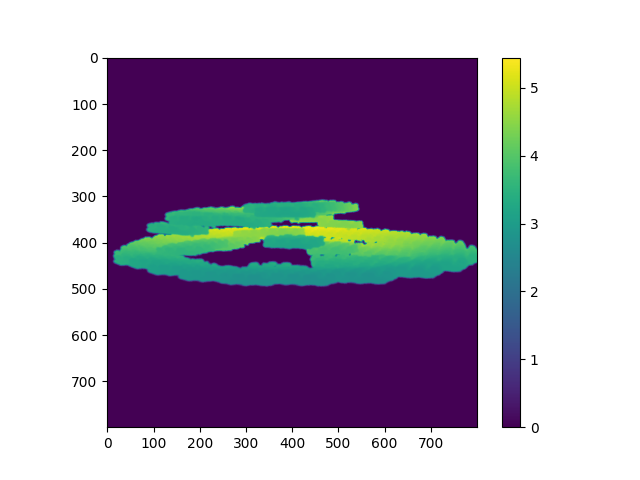

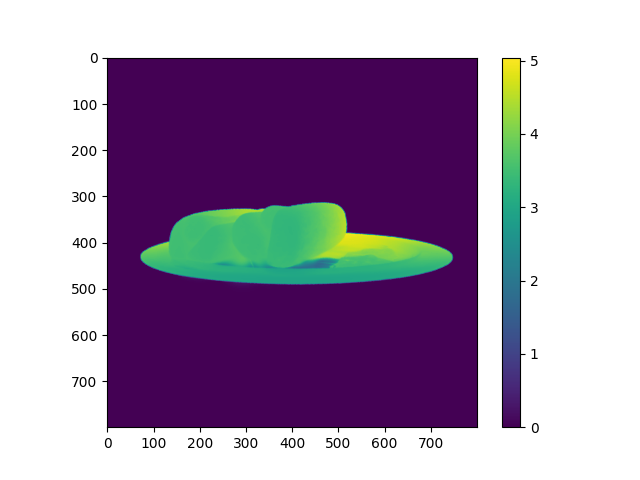

In [582]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

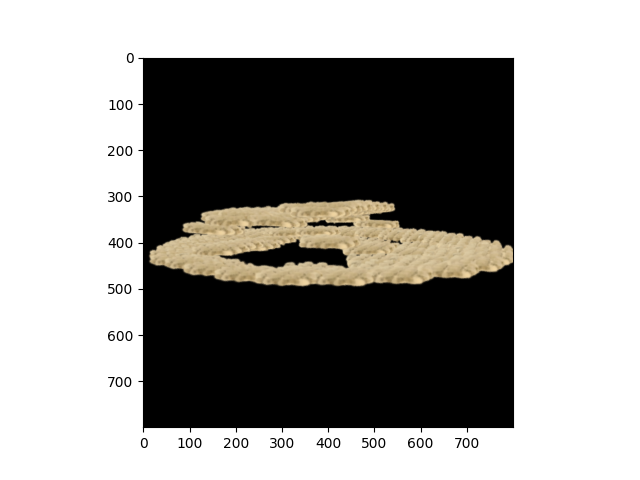

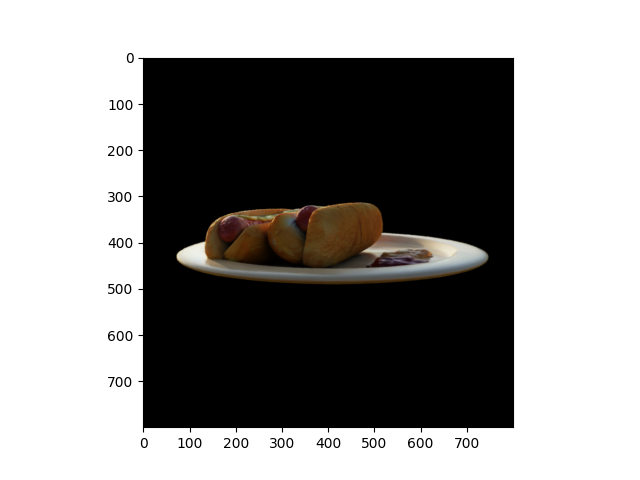

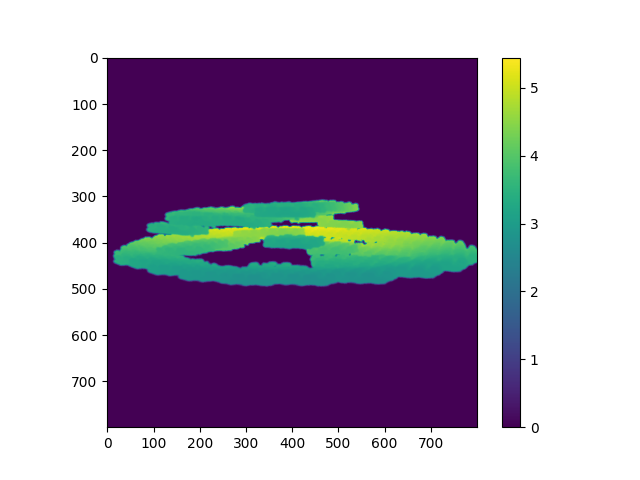

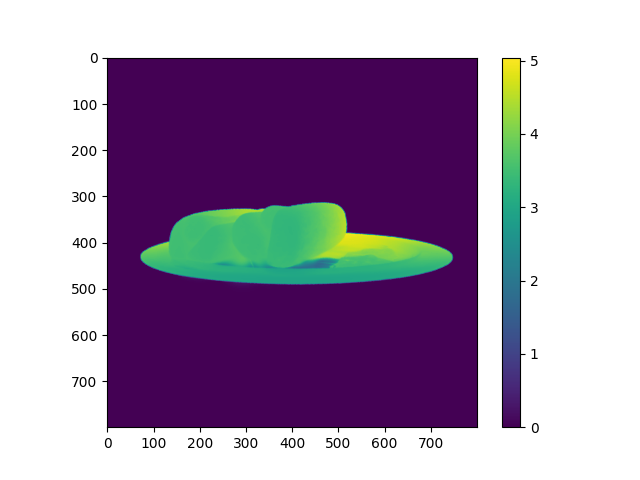

In [583]:
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()





In [ ]:
# Version with smaller gaussians
with torch.no_grad():
    gaussians_opt._scaling.data -= .5
    gaussians_opt._opacity.data -= 0.

render_pkg_novel = render(viewpoint_cam_novel, gaussians_opt, pipe, background)
image, depth= render_pkg_novel["render"], render_pkg_novel["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()




with torch.no_grad():
    gaussians_opt._scaling.data += .5
    gaussians_opt._opacity.data += 0.

In [62]:
N, C, N*C, gaussians_opt._xyz.shape

(2714, 80, 217120, torch.Size([217120, 3]))

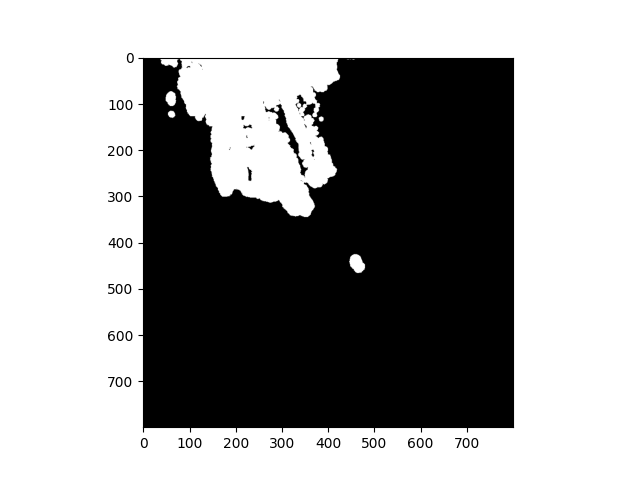

In [176]:
image_rgb = (image>0.).detach().cpu().numpy().transpose(1, 2, 0).astype(np.float32)
plt.figure()
plt.imshow(image_rgb)
plt.show()


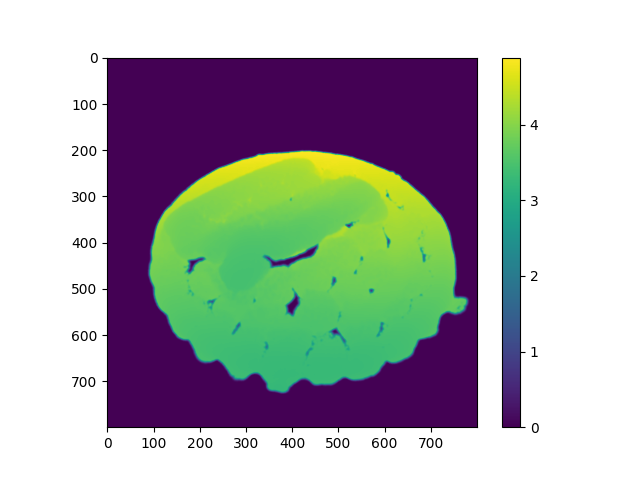

In [113]:
from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(3, 3), sigma=(3., 3.))

depth_np = (blurrer(depth.unsqueeze(0)).squeeze(0)).detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [119]:


depth_np = gaussian_filter_2d(depth, sigma=1.5).detach().cpu().numpy()


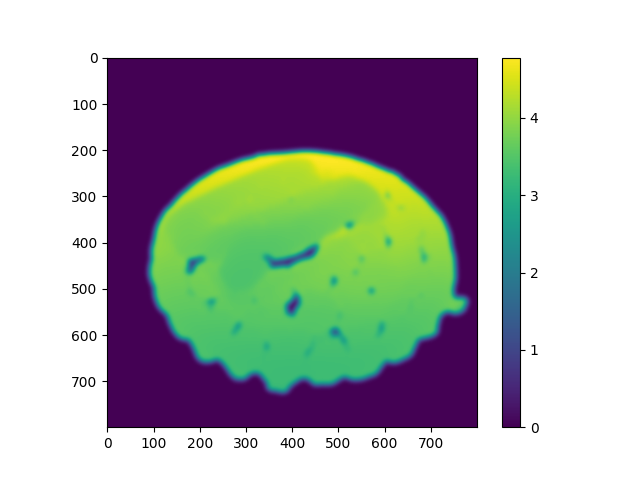

In [124]:
from math import ceil

import torch
from torch.nn.functional import conv2d
from torch.distributions import Normal

# Taken from here https://stackoverflow.com/questions/60534909/gaussian-filter-in-pytorch
def gaussian_kernel_1d(sigma: float, num_sigmas: float = 3.) -> torch.Tensor:
    
    radius = ceil(num_sigmas * sigma)
    support = torch.arange(-radius, radius + 1, dtype=torch.float)
    kernel = Normal(loc=0, scale=sigma).log_prob(support).exp_()
    # Ensure kernel weights sum to 1, so that image brightness is not altered
    return kernel.mul_(1 / kernel.sum()).cuda()

def gaussian_filter_2d(img: torch.Tensor, sigma: float) -> torch.Tensor:
    
    kernel_1d = gaussian_kernel_1d(sigma)  # Create 1D Gaussian kernel
    
    padding = len(kernel_1d) // 2  # Ensure that image size does not change
    img = img.unsqueeze(0).unsqueeze_(0)  # Need 4D data for ``conv2d()``
    # Convolve along columns and rows
    img = conv2d(img, weight=kernel_1d.view(1, 1, -1, 1), padding=(padding, 0))
    img = conv2d(img, weight=kernel_1d.view(1, 1, 1, -1), padding=(0, padding))
    return img.squeeze_(0).squeeze_(0)  # Make 2D again

# img_filtered = gaussian_filter_2d(img, sigma=1.5)



depth_np = gaussian_filter_2d(depth, sigma=5.5).detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


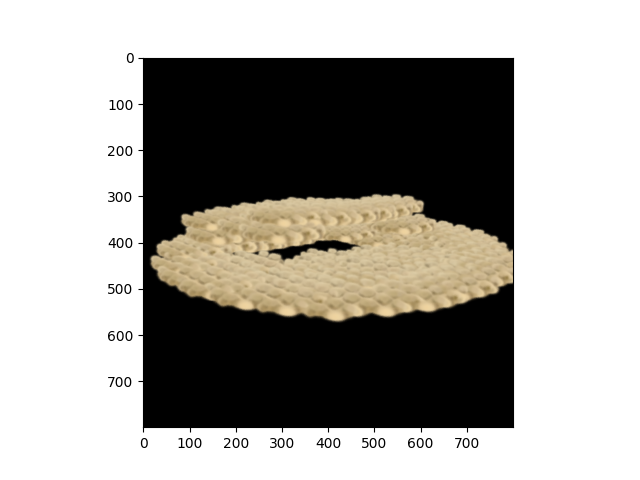

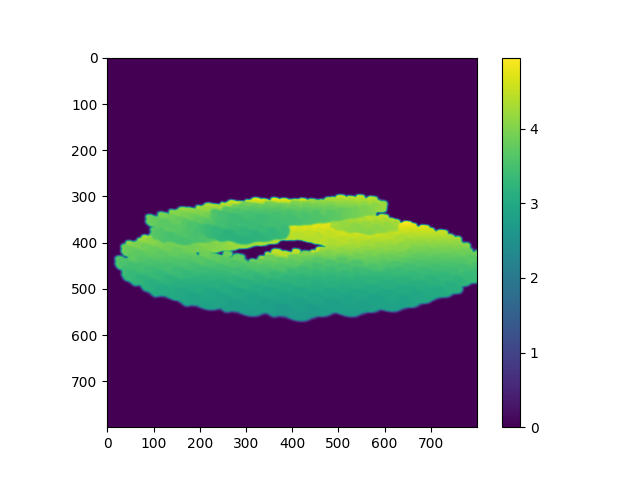

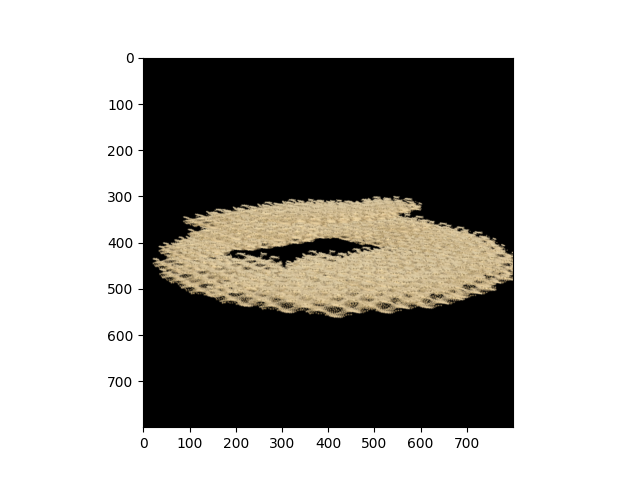

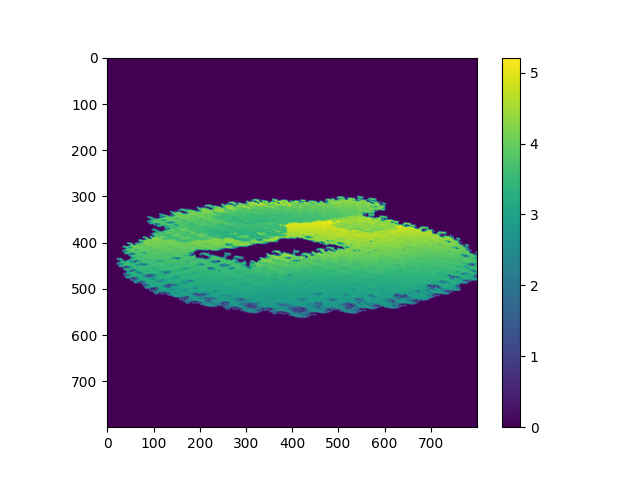

In [386]:
viewpoint_cam_novel = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_novel = render(viewpoint_cam_novel, gaussians_opt, pipe, background)
image, depth= render_pkg_novel["render"], render_pkg_novel["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


with torch.no_grad():
    gaussians_opt._scaling.data -= 1.5
    gaussians_opt._opacity.data -= 10.

render_pkg_novel = render(viewpoint_cam_novel, gaussians_opt, pipe, background)
image, depth= render_pkg_novel["render"], render_pkg_novel["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


with torch.no_grad():
    gaussians_opt._scaling.data += 1.5
    gaussians_opt._opacity.data += 10.

In [60]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
MODEL_DIR_NEW = './GT_lego_cluster2_good_init_optim_color4/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR




In [61]:
! ls {MODEL_DIR_NEW}

camera_paths  cfg_args	   input.ply	point_cloud
cameras.json  chkpnt1.pth  iteration_1


In [62]:

iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))
